# JobParser

The general strategy is:
    1. Parse the top 15 pages job links of data science on Indeed and collect all contents in each job.
    2. Process the job contents and either dig out information or create a dynamic job board for my own use

In [2]:
from bs4 import BeautifulSoup # For HTML parsing
import urllib.request as ub
import re # Regular expressions
from time import sleep # To prevent overwhelming the server between connections
from collections import Counter # Keep track of our term counts
from nltk.corpus import stopwords # Filter out stopwords, such as 'the', 'or', 'and'
import pandas as pd # For converting results to a dataframe and bar chart plots
import time 
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Website parsing function

In [3]:
def text_extractor(website):
    '''
    extract words from html file
    '''
    try:
        site = ub.urlopen(website).read() # Connect to the job posting
    except: 
        return   # Need this in case the website isn't there anymore or some other weird connection problem 
    
    soupObj = BeautifulSoup(site,"lxml") # Get the html from the site
    
    for script in soupObj(["script", "style"]):
        script.extract() # Remove these two elements from the BS4 object
    
    text = soupObj.get_text() # Get the text from this
    
        
    
    lines = (line.strip() for line in text.splitlines()) # break into lines
        
        
    chunks = (phrase.strip() for line in lines for phrase in line.split("  ")) # break multi-headlines into a line each

        
    text = re.sub("[^a-zA-Z.+3]"," ", text)  # Now get rid of any terms that aren't words (include 3 for d3.js)
                                                # Also include + for C++
        
    text = text.lower().split()  # Go to lower case and split them apart
            
    text = list(set(text)) # Last, just get the set of these. Ignore counts (we are just looking at whether a term existed
                            # or not on the website)
    return text

In [4]:
sample = text_extractor('http://www.indeed.com/viewjob?jk=5505e59f8e5a32a4&q=%22data+scientist%22&tk=19ftfgsmj19ti0l3&from=web&advn=1855944161169178&sjdu=QwrRXKrqZ3CNX5W-O9jEvWC1RT2wMYkGnZrqGdrncbKqQ7uwTLXzT1_ME9WQ4M-7om7mrHAlvyJT8cA_14IV5w&pub=pub-indeed')
# sample[:20] # Just show the first 20 words

Grab all the job link on indeed

In [5]:
webStart = "http://www.indeed.com/jobs?q=data+science&jt=fulltime&fromage=1&start=0&pp="

In [6]:
def pageGenerator(n):
    
    """
    return the link of pages that will be used
    """
    links = []
    for i in range(n):
        front = "http://www.indeed.com/jobs?q=data+science&jt=fulltime&fromage=1&start="
        end = "&pp="
        links.append("".join([front,str(i*10),end]))
    return links

def completeLink(link):
    return "http://www.indeed.com" + link

Get all links to job pages on one indeed webpage

In [7]:
def jobLinkCollector(pageAddr):
    
    # load page
    site = ub.urlopen(pageAddr).read()
    soupObj = BeautifulSoup(site,"lxml")
    
    # find the division for the fixed 10 jobs on one page
    jobs = soupObj.find_all("div",attrs = {"data-tn-component":"organicJob"})
    jobLink = []
    
    # iteration for get the link of each job site
    for i in range(len(jobs)):
        link = jobs[i].find("a",attrs={"data-tn-element":"jobTitle"}).get("href")
        jobLink.append(completeLink(link))
    
    return jobLink

Collect the job information

In [8]:
def allJobLinks(n):
    
    # generate the pages for indeed jobs
    jobPages = pageGenerator(n)
    
    jobLinks = []
    
    for page in range(len(jobPages)):
        jobLinks.extend(jobLinkCollector(jobPages[page]))
    
    return jobLinks    

In [8]:
allLinks = allJobLinks(20)
infoList = []

In [9]:
for link in tqdm(allLinks):
    
    infoList.append(text_extractor(link))
    time.sleep(0.5)

100%|██████████| 200/200 [04:15<00:00,  1.03s/it]


define a word count function for one page

In [39]:
import numpy as np

def skillWordCount(textList,skillList):
    """
    This function is used to count the skills on each webpage
    """
    skillDict = dict((el,0) for el in skillList)
    
    for text in textList:
        for i in skillList:
            skillDict[i] += int((np.array(text)==i).sum())
    
    return skillDict

Define the dictionary

In [68]:
skillList = ['r','python','java','c++','ruby','perl','matlab','javascript','scala','excel','tableau',
                'd3.js','sas','d3','spss','hadoop','mapreduce','spark','pig','hive','zookeeper',
                'oozie','mahout','flume','sql','nosql','hbase','cassandra','mongodb']

Count the words

In [12]:
wordCount = pd.Series(skillWordCount(infoList,skillList)).sort_values(ascending=False)

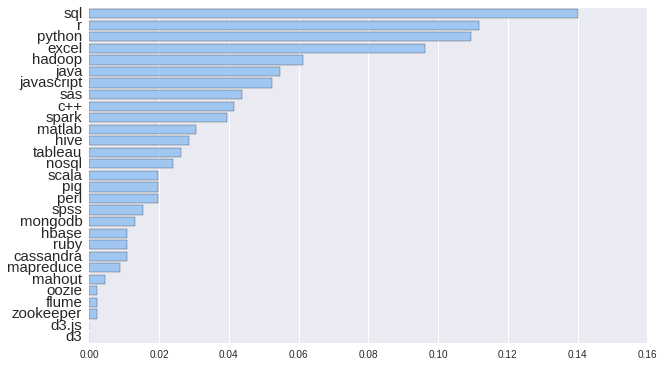

In [13]:
sns.set_color_codes("pastel")
plt.figure(figsize = (10,6));
sns.barplot(y=wordCount.index,x=wordCount.values/sum(wordCount.values),color="b");
plt.yticks(fontsize = 15);

SQL R and Python are the most popular skills needed. The result is from the ***latest*** 200 data science job post on the Indeed website. 

# Get location data

In [36]:
def jobLocCollector(pageAddr):
    
    # load page
    site = ub.urlopen(pageAddr).read()
    soupObj = BeautifulSoup(site,"lxml")
    
    # find the division for the fixed 10 jobs on one page
    jobs = soupObj.find_all("div",attrs = {"data-tn-component":"organicJob"})
    jobLoc = []
    
    # iteration for get the link of each job site
    for i in range(len(jobs)):
        loc = jobs[i].find("span",attrs={"itemprop":"addressLocality"}).contents[0]
        loc = ''.join(i for i in loc if not i.isdigit()).strip()
        jobLoc.append(loc)
    
    return jobLoc

In [37]:
pageAddr = "https://www.indeed.com/jobs?q=data+scientist&l="

In [38]:
jobLocCollector(pageAddr)

['Seattle, WA',
 'Menlo Park, CA',
 'San Francisco, CA',
 'Jersey City, NJ',
 'Washington, DC',
 'Altadena, CA',
 'Boston, MA',
 'New York, NY',
 'San Francisco, CA',
 'San Francisco, CA']

***Combine code to get a list containing the location and job skill information***

In [63]:
def allJobInfo(n):
    
    # generate the pages for indeed jobs
    jobPages = pageGenerator(n)
    
    jobInfo= []
    
    for page in range(len(jobPages)):
        links = jobLinkCollector(jobPages[page])
        locs = jobLocCollector(jobPages[page])
        info = [(x,y) for x,y in zip(links,locs)]
        jobInfo.extend(info)
    
    return jobInfo

In [64]:
allInfo = allJobInfo(2)
infoList = []

In [67]:
for item in tqdm(allInfo):
    infoList.append(text_extractor(item[0]))
    time.sleep(0.5)

100%|██████████| 20/20 [00:37<00:00,  1.90s/it]


In [73]:
import numpy as np

def locSkill(textList,skillList):
    """
    This function is used to get skill and loc info
    """ 
    
    res = []
    for i in range(len(textList)):
        skillDict = dict((el,0) for el in skillList)
        for j in skillList:
            skillDict[j] += int((np.array(textList[i])==j).sum())
        res.append([skillDict,allInfo[i][1]])
        
    
    return res

finalInfo contains the loc and skill counts

In [74]:
finalInfo = locSkill(infoList,skillList)